## Assessing the influence of antibody reliability on mRNA-protein correlation for proteins measured using RPPA 

**Input:**  
- Processed antibody validation status (Source Data for Figure S1)
- Transcriptomics and protein expression data for breast cancer (BrCa), ovarian cancer (Ovarian), colorectal adenocarcinoma (CoadRead), endometrial carcinoma (UCEC), kidney renal carcinoma (KIRC), and low grade glioma (Brain). 

**Output:**  
- Figure 1 and S2

### Import Packages

In [1]:
import os, re
import numpy as np
import pandas as pd

%matplotlib inline
import seaborn as sns 
from matplotlib import pyplot as plt

import graphing_utils
import customized_plot
import standardised_pipeline_utils

In [2]:
get_data_path = lambda folders, fname: os.path.normpath(os.environ['DATA_PATH']+'/'+'/'.join(folders) +'/'+ fname)
get_table_path = lambda fname: os.path.normpath('../tables/' + fname)
get_figure_path = lambda fname: os.path.normpath('../figures/' + fname)

In [3]:
file_pancan_mRNA = get_data_path(['usc_xena_browser'], 'EB++AdjustPANCAN_IlluminaHiSeq_RNASeqV2.geneExp.xena')
file_pancan_rppa = get_data_path(['usc_xena_browser'], 'TCGA-RPPA-pancan-clean.xena')
file_sample_cancer_map = get_data_path(['gdc_cancer_gov'], 'TCGA-RPPA-pancan-clean.txt')

file_sourceData_Figure1 = get_table_path('SourceDataForFigure1.csv')
file_sourceData_FigureS1 = get_table_path('SourceDataForFigureS1.csv')
file_sourceData_FigureS2 = get_table_path('SourceDataForFigureS2.csv')

### Load Data

In [4]:
sample_cancer_map = pd.read_csv(file_sample_cancer_map, sep='\t', usecols=['SampleID', 'TumorType'])
print("Dimensions:", sample_cancer_map.shape)
sample_cancer_map[:2]

Dimensions: (7790, 2)


,SampleID,TumorType
0,TCGA-OR-A5J2-01A-21-A39K-20,ACC
1,TCGA-PA-A5YG-01A-21-A39K-20,ACC


In [5]:
sample_cancer_map['SampleID'] = sample_cancer_map['SampleID'].apply(lambda x: x[:15])
sample_cancer_map = sample_cancer_map.drop_duplicates(keep='first')
sample_cancer_map.shape

(7790, 2)

In [6]:
sample_cancer_map[sample_cancer_map['TumorType'].isin(['BRCA', 'CORE', 'KIRC', 'UCEC', 'LGG', 'OV'])]['TumorType'].value_counts()

BRCA    892
CORE    498
KIRC    478
UCEC    440
OV      436
LGG     435
Name: TumorType, dtype: int64

#### Transcriptomics Data

In [7]:
pancan_mRNA = pd.read_csv(file_pancan_mRNA, sep='\t', index_col=0)
print("Dimensions:", pancan_mRNA.shape)
pancan_mRNA[:2]

Dimensions: (20531, 11069)


,TCGA-OR-A5J1-01,TCGA-OR-A5J2-01,TCGA-OR-A5J3-01,TCGA-OR-A5J5-01,TCGA-OR-A5J6-01,TCGA-OR-A5J7-01,TCGA-OR-A5J8-01,TCGA-OR-A5J9-01,TCGA-OR-A5JA-01,TCGA-OR-A5JB-01,...,TCGA-CG-4449-01,TCGA-CG-4462-01,TCGA-CG-4465-01,TCGA-CG-4466-01,TCGA-CG-4469-01,TCGA-CG-4472-01,TCGA-CG-4474-01,TCGA-CG-4475-01,TCGA-CG-4476-01,TCGA-CG-4477-01
sample,,,,,,,,,,,,,,,,,,,,,
100130426,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100133144,2.09,1.88,1.45,0.0,0.0,1.12,1.29,0.0,2.45,3.02,...,2.42,2.74,2.64,3.99,4.4,3.0,4.27,3.71,4.29,4.24


In [8]:
pancan_mRNA = pancan_mRNA.rename(columns = lambda x: x[:15])
pancan_mRNA[:2]

,TCGA-OR-A5J1-01,TCGA-OR-A5J2-01,TCGA-OR-A5J3-01,TCGA-OR-A5J5-01,TCGA-OR-A5J6-01,TCGA-OR-A5J7-01,TCGA-OR-A5J8-01,TCGA-OR-A5J9-01,TCGA-OR-A5JA-01,TCGA-OR-A5JB-01,...,TCGA-CG-4449-01,TCGA-CG-4462-01,TCGA-CG-4465-01,TCGA-CG-4466-01,TCGA-CG-4469-01,TCGA-CG-4472-01,TCGA-CG-4474-01,TCGA-CG-4475-01,TCGA-CG-4476-01,TCGA-CG-4477-01
sample,,,,,,,,,,,,,,,,,,,,,
100130426,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100133144,2.09,1.88,1.45,0.0,0.0,1.12,1.29,0.0,2.45,3.02,...,2.42,2.74,2.64,3.99,4.4,3.0,4.27,3.71,4.29,4.24


In [9]:
#Check for duplicated columns after modifying the sample: 
pancan_mRNA[pancan_mRNA.columns[pancan_mRNA.columns.duplicated()].to_list()]

,TCGA-21-1076-01,TCGA-21-1076-01,TCGA-DD-AACA-02,TCGA-DD-AACA-02,TCGA-06-0156-01,TCGA-06-0156-01,TCGA-06-0211-01,TCGA-06-0211-01,TCGA-DU-6404-02,TCGA-DU-6404-02,TCGA-DU-6407-02,TCGA-DU-6407-02,TCGA-FG-5965-02,TCGA-FG-5965-02,TCGA-TQ-A7RK-02,TCGA-TQ-A7RK-02,TCGA-23-1023-01,TCGA-23-1023-01
sample,,,,,,,,,,,,,,,,,,
100130426,0.00,0.00,1.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN
100133144,3.43,1.71,2.74,0.00,4.27,4.42,2.90,2.17,5.76,6.72,0.00,2.61,1.29,0.77,1.83,3.86,3.46,3.50
100134869,2.09,2.10,2.90,2.89,3.47,2.76,2.55,2.82,5.92,6.90,3.29,3.30,4.25,3.07,3.98,3.92,3.81,2.52
10357,6.88,6.66,6.50,6.09,5.37,5.81,5.29,5.77,6.76,7.86,6.41,7.23,7.33,6.94,7.46,6.94,6.90,7.98
10431,9.30,9.40,9.89,10.93,9.00,8.97,8.92,8.77,9.84,9.93,10.24,9.87,9.40,9.90,8.80,8.53,10.59,10.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11A,5.05,5.41,7.32,6.50,0.63,1.40,0.00,1.38,4.52,4.26,0.00,1.24,2.08,0.96,0.45,0.99,2.70,6.65
ZYG11B,9.58,9.60,10.88,9.91,10.54,10.47,9.86,10.22,10.05,9.73,9.61,10.53,10.56,11.25,10.36,10.64,9.44,9.65
ZYX,12.43,12.64,10.03,9.61,11.99,11.89,14.32,14.46,11.50,11.16,11.55,13.07,12.07,10.94,10.87,10.50,12.82,12.27


<div class="alert alert-block alert-info">
    Since the duplicate samples seem to have similar values, we can aggregated using the mean function.   
</div>

In [10]:
#Check for duplicated entries for the same gene: 
pancan_mRNA.loc[pancan_mRNA.index[pancan_mRNA.index.duplicated()].to_list()]

,TCGA-OR-A5J1-01,TCGA-OR-A5J2-01,TCGA-OR-A5J3-01,TCGA-OR-A5J5-01,TCGA-OR-A5J6-01,TCGA-OR-A5J7-01,TCGA-OR-A5J8-01,TCGA-OR-A5J9-01,TCGA-OR-A5JA-01,TCGA-OR-A5JB-01,...,TCGA-CG-4449-01,TCGA-CG-4462-01,TCGA-CG-4465-01,TCGA-CG-4466-01,TCGA-CG-4469-01,TCGA-CG-4472-01,TCGA-CG-4474-01,TCGA-CG-4475-01,TCGA-CG-4476-01,TCGA-CG-4477-01
sample,,,,,,,,,,,,,,,,,,,,,
SLC35E2,11.69,9.70,10.28,10.19,11.51,9.13,10.63,10.40,10.35,10.65,...,10.92,10.86,10.49,10.83,10.98,10.44,10.88,10.75,11.90,10.00
SLC35E2,5.18,4.48,3.97,3.01,5.45,4.04,5.14,4.58,5.06,4.59,...,6.64,6.60,4.74,5.16,5.72,4.46,6.02,5.28,6.35,4.27


<div class="alert alert-block alert-info">
    Since the duplicate records for the gene SLC35E2 have differing values, let's drop the second record.
</div>

In [11]:
pancan_mRNA = pancan_mRNA.groupby(pancan_mRNA.columns, axis=1).mean()
pancan_mRNA = pancan_mRNA[~pancan_mRNA.index.duplicated(keep='first')]
pancan_mRNA.shape

(20530, 11060)

In [12]:
brca_gene_expression = pancan_mRNA.reindex(sample_cancer_map[sample_cancer_map['TumorType'] == 'BRCA']['SampleID'], axis=1)
ovca_gene_expression = pancan_mRNA.reindex(sample_cancer_map[sample_cancer_map['TumorType'] == 'OV']['SampleID'], axis=1)
coadread_gene_expression = pancan_mRNA.reindex(sample_cancer_map[sample_cancer_map['TumorType'] == 'CORE']['SampleID'], axis=1)
ucec_gene_expression = pancan_mRNA.reindex(sample_cancer_map[sample_cancer_map['TumorType'] == 'UCEC']['SampleID'], axis=1)
kirc_gene_expression = pancan_mRNA.reindex(sample_cancer_map[sample_cancer_map['TumorType'] == 'KIRC']['SampleID'], axis=1)
lgg_gene_expression = pancan_mRNA.reindex(sample_cancer_map[sample_cancer_map['TumorType'] == 'LGG']['SampleID'], axis=1)

#### Protein Expression (RPPA)

In [13]:
pancan_rppa = pd.read_csv(file_pancan_rppa, sep='\t')#, index_col=0)
print("Dimensions:", pancan_rppa.shape)
pancan_rppa[:2]

Dimensions: (258, 7755)


,SampleID,TCGA-FI-A2EY-01,TCGA-DF-A2KS-01,TCGA-A5-A1OH-01,TCGA-AX-A2H7-01,TCGA-AX-A2HA-01,TCGA-A5-A2K4-01,TCGA-EY-A2OM-01,TCGA-EY-A2ON-01,TCGA-E6-A2P8-01,...,TCGA-RD-A8N0-01,TCGA-RD-A8MW-01,TCGA-VQ-A8E2-01,TCGA-VQ-A8E0-01,TCGA-VQ-A8DL-01,TCGA-VQ-A8DU-01,TCGA-VQ-A8DT-01,TCGA-IN-A7NR-01,TCGA-RD-A8MV-01,TCGA-KB-A93G-01
0,X1433EPSILON,-0.013829,-0.16863,0.038842,0.021308,0.108640,-0.24198,0.051101,0.183180,-0.062962,...,-0.30092,-0.006139,-0.022418,0.001432,0.027505,-0.048516,-0.13928,-0.23253,-0.019379,-0.064041
1,X4EBP1,-1.127400,0.16587,-0.382370,-0.717660,0.090459,-0.37866,-0.044557,-0.053956,0.008223,...,-0.48837,-0.321200,-0.386970,0.018423,-0.325220,-0.073244,-0.16909,-0.50985,0.250550,-0.247550


In [14]:
pancan_rppa.rename(columns={'SampleID':'ProteinName'}, inplace=True)
pancan_rppa[:2]

,ProteinName,TCGA-FI-A2EY-01,TCGA-DF-A2KS-01,TCGA-A5-A1OH-01,TCGA-AX-A2H7-01,TCGA-AX-A2HA-01,TCGA-A5-A2K4-01,TCGA-EY-A2OM-01,TCGA-EY-A2ON-01,TCGA-E6-A2P8-01,...,TCGA-RD-A8N0-01,TCGA-RD-A8MW-01,TCGA-VQ-A8E2-01,TCGA-VQ-A8E0-01,TCGA-VQ-A8DL-01,TCGA-VQ-A8DU-01,TCGA-VQ-A8DT-01,TCGA-IN-A7NR-01,TCGA-RD-A8MV-01,TCGA-KB-A93G-01
0,X1433EPSILON,-0.013829,-0.16863,0.038842,0.021308,0.108640,-0.24198,0.051101,0.183180,-0.062962,...,-0.30092,-0.006139,-0.022418,0.001432,0.027505,-0.048516,-0.13928,-0.23253,-0.019379,-0.064041
1,X4EBP1,-1.127400,0.16587,-0.382370,-0.717660,0.090459,-0.37866,-0.044557,-0.053956,0.008223,...,-0.48837,-0.321200,-0.386970,0.018423,-0.325220,-0.073244,-0.16909,-0.50985,0.250550,-0.247550


In [15]:
pancan_rppa['ProteinName'] = pancan_rppa['ProteinName'].replace(r"^X(\d)", r"\1", regex=True)
pancan_rppa[:2]

,ProteinName,TCGA-FI-A2EY-01,TCGA-DF-A2KS-01,TCGA-A5-A1OH-01,TCGA-AX-A2H7-01,TCGA-AX-A2HA-01,TCGA-A5-A2K4-01,TCGA-EY-A2OM-01,TCGA-EY-A2ON-01,TCGA-E6-A2P8-01,...,TCGA-RD-A8N0-01,TCGA-RD-A8MW-01,TCGA-VQ-A8E2-01,TCGA-VQ-A8E0-01,TCGA-VQ-A8DL-01,TCGA-VQ-A8DU-01,TCGA-VQ-A8DT-01,TCGA-IN-A7NR-01,TCGA-RD-A8MV-01,TCGA-KB-A93G-01
0,1433EPSILON,-0.013829,-0.16863,0.038842,0.021308,0.108640,-0.24198,0.051101,0.183180,-0.062962,...,-0.30092,-0.006139,-0.022418,0.001432,0.027505,-0.048516,-0.13928,-0.23253,-0.019379,-0.064041
1,4EBP1,-1.127400,0.16587,-0.382370,-0.717660,0.090459,-0.37866,-0.044557,-0.053956,0.008223,...,-0.48837,-0.321200,-0.386970,0.018423,-0.325220,-0.073244,-0.16909,-0.50985,0.250550,-0.247550


In [16]:
antibody_status = pd.read_csv(file_sourceData_FigureS1)
antibody_status[:2]

,ProteinName,GeneName,ValidationStatus
0,1433EPSILON,YWHAE,Use with Caution
1,4EBP1,EIF4EBP1,Valid


In [17]:
merged_pancan_data = pancan_rppa.merge(antibody_status, left_on='ProteinName', 
                  right_on='ProteinName', how='inner').set_index('GeneName').drop(columns=['ProteinName', 'ValidationStatus'])
print("Dimensions: ", merged_pancan_data.shape)
merged_pancan_data[:2]

Dimensions:  (110, 7754)


,TCGA-FI-A2EY-01,TCGA-DF-A2KS-01,TCGA-A5-A1OH-01,TCGA-AX-A2H7-01,TCGA-AX-A2HA-01,TCGA-A5-A2K4-01,TCGA-EY-A2OM-01,TCGA-EY-A2ON-01,TCGA-E6-A2P8-01,TCGA-E6-A2P9-01,...,TCGA-RD-A8N0-01,TCGA-RD-A8MW-01,TCGA-VQ-A8E2-01,TCGA-VQ-A8E0-01,TCGA-VQ-A8DL-01,TCGA-VQ-A8DU-01,TCGA-VQ-A8DT-01,TCGA-IN-A7NR-01,TCGA-RD-A8MV-01,TCGA-KB-A93G-01
GeneName,,,,,,,,,,,,,,,,,,,,,
YWHAE,-0.013829,-0.16863,0.038842,0.021308,0.108640,-0.24198,0.051101,0.183180,-0.062962,-0.044199,...,-0.30092,-0.006139,-0.022418,0.001432,0.027505,-0.048516,-0.13928,-0.23253,-0.019379,-0.064041
EIF4EBP1,-1.127400,0.16587,-0.382370,-0.717660,0.090459,-0.37866,-0.044557,-0.053956,0.008223,-0.085437,...,-0.48837,-0.321200,-0.386970,0.018423,-0.325220,-0.073244,-0.16909,-0.50985,0.250550,-0.247550


In [18]:
merged_pancan_data.columns[merged_pancan_data.columns.duplicated()]

Index([], dtype='object')

In [19]:
merged_pancan_data.index[merged_pancan_data.index.duplicated()]

Index([], dtype='object', name='GeneName')

<div class="alert alert-block alert-info">
    There are no duplicate samples or proteins in the data!
</div>

In [20]:
brca_protein_expression = merged_pancan_data.reindex(sample_cancer_map[sample_cancer_map['TumorType'] == 'BRCA']['SampleID'], axis=1)
ovca_protein_expression = merged_pancan_data.reindex(sample_cancer_map[sample_cancer_map['TumorType'] == 'OV']['SampleID'], axis=1)
coadread_protein_expression = merged_pancan_data.reindex(sample_cancer_map[sample_cancer_map['TumorType'] == 'CORE']['SampleID'], axis=1)
ucec_protein_expression = merged_pancan_data.reindex(sample_cancer_map[sample_cancer_map['TumorType'] == 'UCEC']['SampleID'], axis=1)
kirc_protein_expression = merged_pancan_data.reindex(sample_cancer_map[sample_cancer_map['TumorType'] == 'KIRC']['SampleID'], axis=1)
lgg_protein_expression = merged_pancan_data.reindex(sample_cancer_map[sample_cancer_map['TumorType'] == 'LGG']['SampleID'], axis=1)

#### Applying standardised pipeline and computing correlation

In [21]:
brca_gene_expression_processed, brca_protein_expression_processed =  standardised_pipeline_utils.match_proteins_samples( \
                                                                            brca_gene_expression, brca_protein_expression)
brca_mRNA_RPPA_cor = standardised_pipeline_utils.correlate_genewise(brca_gene_expression_processed, 
                                                                    brca_protein_expression_processed, 
                                                                   'BrCa')

Number of common proteins:  106
Number of common samples:  892
Median Spearman Correlation:  0.3603


In [22]:
ovca_gene_expression_processed, ovca_protein_expression_processed =  standardised_pipeline_utils.match_proteins_samples( \
                                                                            ovca_gene_expression, ovca_protein_expression)
ovca_mRNA_RPPA_cor = standardised_pipeline_utils.correlate_genewise(ovca_gene_expression_processed, 
                                                                    ovca_protein_expression_processed, 
                                                                   'Ovarian')

Number of common proteins:  106
Number of common samples:  436
Median Spearman Correlation:  0.4995


In [23]:
coadread_gene_expression_processed, coadread_protein_expression_processed =  standardised_pipeline_utils.match_proteins_samples( \
                                                                            coadread_gene_expression, coadread_protein_expression)
coadread_mRNA_RPPA_cor = standardised_pipeline_utils.correlate_genewise(coadread_gene_expression_processed, 
                                                                        coadread_protein_expression_processed, 
                                                                   'CoadRead')

Number of common proteins:  106
Number of common samples:  498
Median Spearman Correlation:  0.2589


In [24]:
ucec_gene_expression_processed, ucec_protein_expression_processed =  standardised_pipeline_utils.match_proteins_samples( \
                                                                            ucec_gene_expression, ucec_protein_expression)
ucec_mRNA_RPPA_cor = standardised_pipeline_utils.correlate_genewise(ucec_gene_expression_processed, 
                                                                    ucec_protein_expression_processed, 
                                                                   'UCEC')

Number of common proteins:  106
Number of common samples:  440
Median Spearman Correlation:  0.3616


In [25]:
kirc_gene_expression_processed, kirc_protein_expression_processed =  standardised_pipeline_utils.match_proteins_samples( \
                                                                            kirc_gene_expression, kirc_protein_expression)
kirc_mRNA_RPPA_cor = standardised_pipeline_utils.correlate_genewise(kirc_gene_expression_processed, 
                                                                    kirc_protein_expression_processed, 
                                                                   'KIRC')

Number of common proteins:  106
Number of common samples:  478
Median Spearman Correlation:  0.2817


In [26]:
lgg_gene_expression_processed, lgg_protein_expression_processed =  standardised_pipeline_utils.match_proteins_samples( \
                                                                            lgg_gene_expression, lgg_protein_expression)
lgg_mRNA_RPPA_cor = standardised_pipeline_utils.correlate_genewise(lgg_gene_expression_processed, 
                                                                   lgg_protein_expression_processed, 
                                                                   'LGG')

Number of common proteins:  106
Number of common samples:  435
Median Spearman Correlation:  0.2259


In [27]:
combined_mRNA_RPPA_cor = pd.concat([pd.concat([brca_mRNA_RPPA_cor, ovca_mRNA_RPPA_cor, coadread_mRNA_RPPA_cor, 
                                               ucec_mRNA_RPPA_cor, kirc_mRNA_RPPA_cor, lgg_mRNA_RPPA_cor], axis=1), 
                                    antibody_status.set_index('GeneName')['ValidationStatus']], axis=1, join='inner')
combined_mRNA_RPPA_cor.to_csv(file_sourceData_Figure1)
print("Dimensions", combined_mRNA_RPPA_cor.shape)
combined_mRNA_RPPA_cor[:2]

Dimensions (106, 7)


,BrCa,Ovarian,CoadRead,UCEC,KIRC,LGG,ValidationStatus
ACVRL1,0.142387,0.026260,0.119359,0.158536,-0.087107,0.175950,Use with Caution
ANXA7,0.335648,0.431283,0.269618,0.537909,0.479831,0.598215,Valid


In [28]:
xlab = 'Antibody validation status'; ylab = "mRNA-protein (RPPA) correlation"           
palette = [graphing_utils.get_color(color) for color in ['orange', 'green']]
args = [graphing_utils.additional_plot_parameters(xlab=xlab, ylab=ylab, title = 'TCGA Breast (2012)', palette = palette), 
        graphing_utils.additional_plot_parameters(xlab=xlab, ylab=ylab, title = 'TCGA Ovarian (2011)', palette = palette), 
        graphing_utils.additional_plot_parameters(xlab=xlab, ylab=ylab, title = 'TCGA Colorectal (2012)', palette = palette),
        graphing_utils.additional_plot_parameters(xlab=xlab, ylab=ylab, title = 'TCGA Endometrial (2013)', palette = palette),
        graphing_utils.additional_plot_parameters(xlab=xlab, ylab=ylab, title = 'TCGA Kidney (2013)', palette = palette),
        graphing_utils.additional_plot_parameters(xlab=xlab, ylab=ylab, title = 'TCGA Glioma (2015)', palette = palette)]

Use with Caution v.s. Valid:Mann-Whitney-Wilcoxon test two-sided, P_val=9.91E-4 stat= 1.66E+3
Use with Caution v.s. Valid:Mann-Whitney-Wilcoxon test two-sided, P_val=6.63E-3 stat= 1.58E+3
Use with Caution v.s. Valid:Mann-Whitney-Wilcoxon test two-sided, P_val=3.26E-3 stat= 1.61E+3
Use with Caution v.s. Valid:Mann-Whitney-Wilcoxon test two-sided, P_val=7.50E-3 stat= 1.57E+3
Use with Caution v.s. Valid:Mann-Whitney-Wilcoxon test two-sided, P_val=4.97E-6 stat= 1.85E+3
Use with Caution v.s. Valid:Mann-Whitney-Wilcoxon test two-sided, P_val=1.57E-3 stat= 1.64E+3


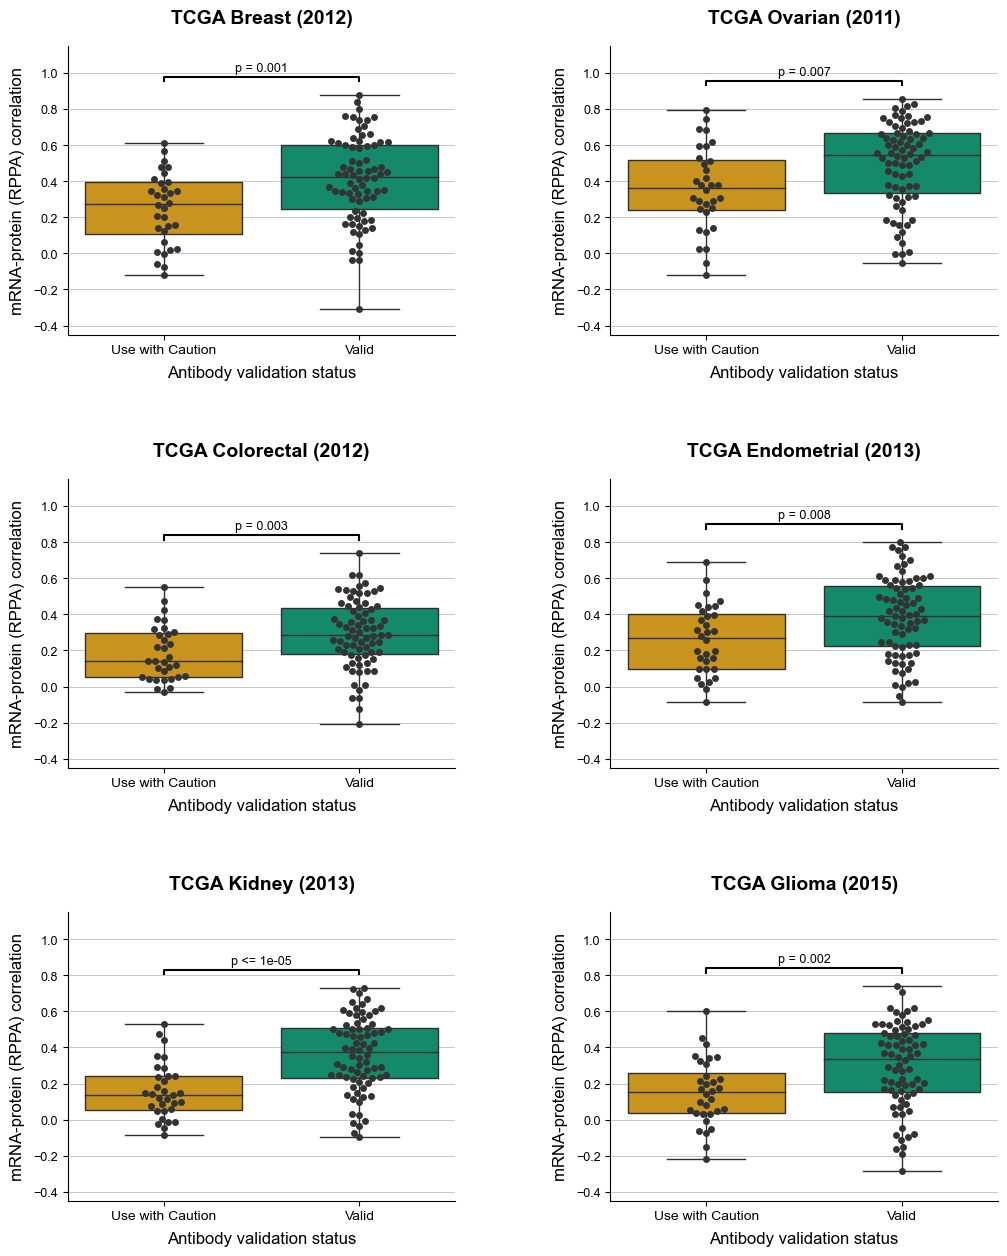

In [29]:
order=['Use with Caution', 'Valid']
with plt.rc_context({'axes.linewidth': 0.8, 'axes.labelsize':12, 'axes.spines.left': True, 'xtick.labelsize':10}):
    figure, ax = plt.subplots(3, 2, figsize=(12, 15))
    customized_plot.draw_swarmBoxPlot(combined_mRNA_RPPA_cor, 'BrCa', ax[0,0], args[0], order)
    customized_plot.draw_swarmBoxPlot(combined_mRNA_RPPA_cor, 'Ovarian', ax[0, 1], args[1], order)
    customized_plot.draw_swarmBoxPlot(combined_mRNA_RPPA_cor, 'CoadRead', ax[1, 0], args[2], order)
    customized_plot.draw_swarmBoxPlot(combined_mRNA_RPPA_cor, 'UCEC', ax[1,1], args[3], order)
    customized_plot.draw_swarmBoxPlot(combined_mRNA_RPPA_cor, 'KIRC', ax[2, 0], args[4], order)
    customized_plot.draw_swarmBoxPlot(combined_mRNA_RPPA_cor, 'LGG', ax[2, 1], args[5], order)
    plt.subplots_adjust(wspace=0.4, hspace=0.5)
#     figure.savefig(get_figure_path('Figure1.svg'), bbox_inches='tight', dpi=300);

<div class="alert alert-block alert-success">
    mRNA-protein correlation for studies with protein expression data from Reverse Phase Protein Arrays are influenced by antibody validation status
</div>

Use with Caution v.s. Valid: t-test-individual two-sided with equal variance, P_val=9.76E-4 stat= 3.39E+0
Use with Caution v.s. Valid: t-test-individual two-sided with equal variance, P_val=7.42E-3 stat= 2.73E+0
Use with Caution v.s. Valid: t-test-individual two-sided with equal variance, P_val=4.77E-3 stat= 2.88E+0
Use with Caution v.s. Valid: t-test-individual two-sided with equal variance, P_val=6.97E-3 stat= 2.75E+0
Use with Caution v.s. Valid: t-test-individual two-sided with equal variance, P_val=3.05E-6 stat= 4.94E+0
Use with Caution v.s. Valid: t-test-individual two-sided with equal variance, P_val=2.72E-3 stat= 3.07E+0


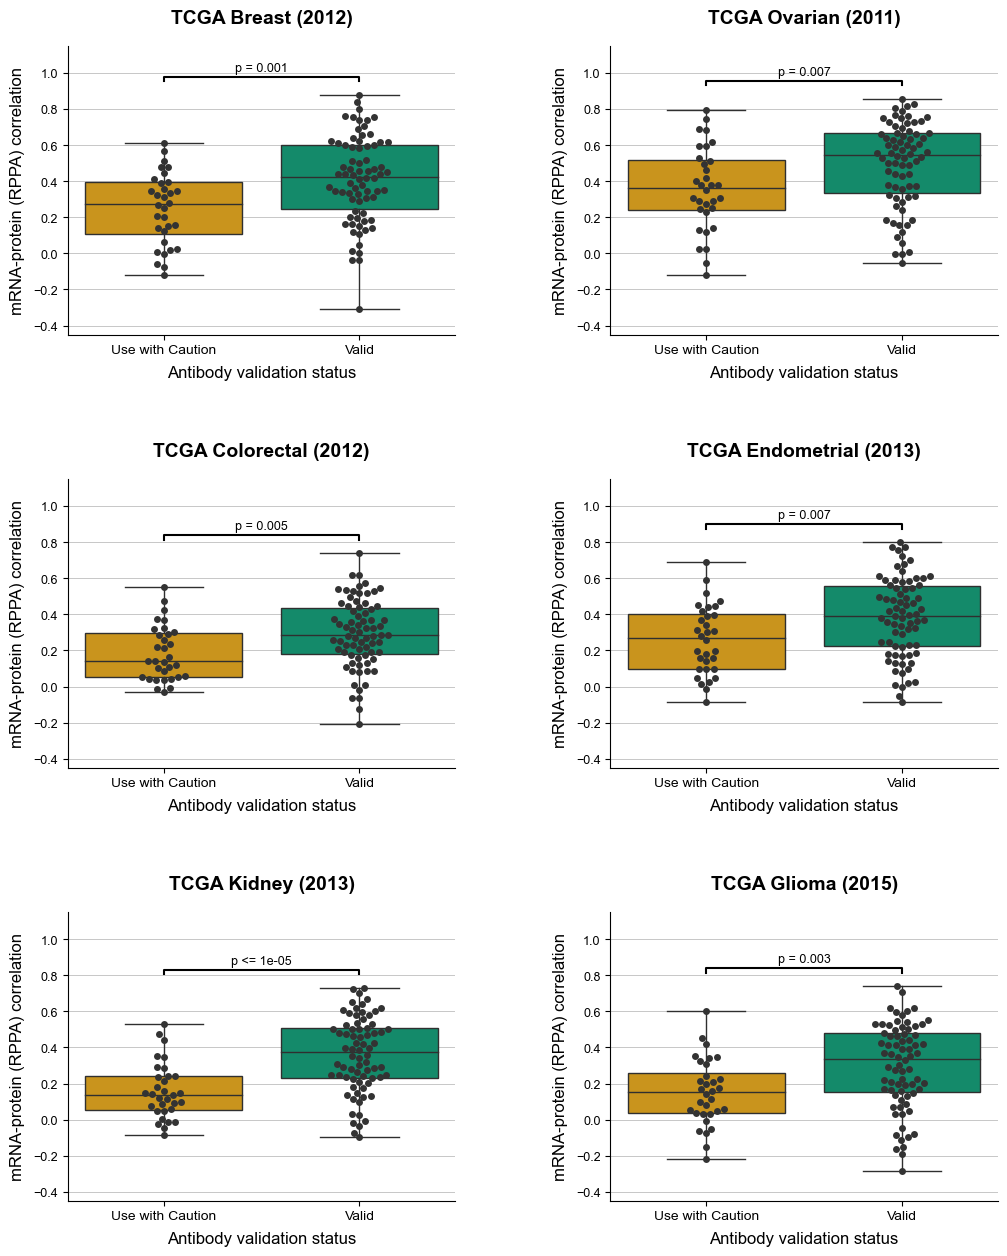

In [30]:
order=['Use with Caution', 'Valid']
with plt.rc_context({'axes.linewidth': 0.8, 'axes.labelsize':12, 'axes.spines.left': True, 'xtick.labelsize':10}):
    figure, ax = plt.subplots(3, 2, figsize=(12, 15))
    customized_plot.draw_swarmBoxPlot(combined_mRNA_RPPA_cor, 'BrCa', ax[0,0], args[0], order, test='t-test_ind')
    customized_plot.draw_swarmBoxPlot(combined_mRNA_RPPA_cor, 'Ovarian', ax[0, 1], args[1], order, test='t-test_ind')
    customized_plot.draw_swarmBoxPlot(combined_mRNA_RPPA_cor, 'CoadRead', ax[1, 0], args[2], order, test='t-test_ind')
    customized_plot.draw_swarmBoxPlot(combined_mRNA_RPPA_cor, 'UCEC', ax[1,1], args[3], order, test='t-test_ind')
    customized_plot.draw_swarmBoxPlot(combined_mRNA_RPPA_cor, 'KIRC', ax[2, 0], args[4], order, test='t-test_ind')
    customized_plot.draw_swarmBoxPlot(combined_mRNA_RPPA_cor, 'LGG', ax[2, 1], args[5], order, test='t-test_ind')
    plt.subplots_adjust(wspace=0.4, hspace=0.5)
#     figure.savefig(get_figure_path('ttest/Figure1_ttest.svg'), bbox_inches='tight', dpi=300);

### Assessing the consistency of antibody derived mRNA-protein correlations across TCGA PanCancer studies

In [31]:
heatmap_table = combined_mRNA_RPPA_cor.corr(numeric_only=True)
heatmap_table.to_csv(file_sourceData_FigureS2)
heatmap_table

,BrCa,Ovarian,CoadRead,UCEC,KIRC,LGG
BrCa,1.000000,0.730695,0.612638,0.748890,0.630622,0.444228
Ovarian,0.730695,1.000000,0.611737,0.707599,0.590091,0.455082
CoadRead,0.612638,0.611737,1.000000,0.700535,0.578655,0.454930
UCEC,0.748890,0.707599,0.700535,1.000000,0.559207,0.554165
KIRC,0.630622,0.590091,0.578655,0.559207,1.000000,0.495184
LGG,0.444228,0.455082,0.454930,0.554165,0.495184,1.000000


In [32]:
mask = []
for i in range(len(heatmap_table.columns)):
    mask_i = []
    for j in range(len(heatmap_table.columns)):
        if j>i:
            mask_i.append(True)
        else: 
            mask_i.append(False)
    mask.append(mask_i)
    
mask = np.array(mask)
mask

array([[False,  True,  True,  True,  True,  True],
       [False, False,  True,  True,  True,  True],
       [False, False, False,  True,  True,  True],
       [False, False, False, False,  True,  True],
       [False, False, False, False, False,  True],
       [False, False, False, False, False, False]])

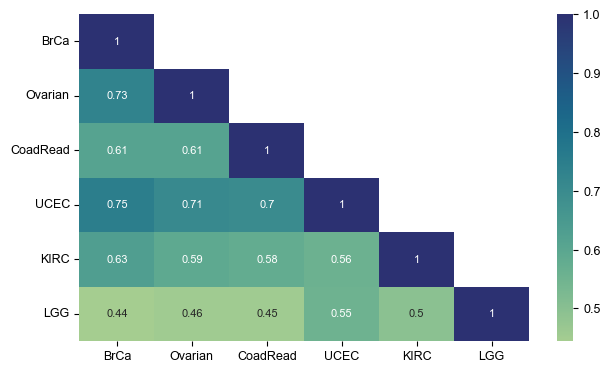

In [33]:
with plt.rc_context({'axes.linewidth': 0.8, 'axes.labelsize':12, 'axes.spines.left': True}):
    figure, ax = plt.subplots(1, 1, figsize=(7.25, 4.25))
    ax = sns.heatmap(heatmap_table, cmap="crest", annot=True, mask=mask, vmax=1, annot_kws={"size":8});
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
#     figure.savefig(get_figure_path('FigureS2.svg'), bbox_inches='tight', dpi=300)